In [1]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig

from keras.utils.visualize_util import plot
from IPython.display import Image, display

from CMS_Deep_Learning.utils.preprocessing import ObjectProfile, preprocessFromPandas_label_dir_pairs, label_dir_pairs_args_decoder
from CMS_Deep_Learning.utils.metrics import plot_history, print_accuracy_m
from CMS_Deep_Learning.utils.callbacks import OverfitStopping, SmartCheckpoint
from CMS_Deep_Learning.utils.archiving import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D, merge, Input, Flatten
from keras.callbacks import EarlyStopping

#Choose the GPU
dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.
using gpu0
using theano


In [2]:
#Set up all of our preprocessing parameters
observ_types = ['E/c', 'Px', 'Py', 'Pz', 'Charge', "PT_ET", "Eta", "Phi", "Dxy", "Ehad", "Eem"]
vecsize = len(observ_types)
sample_start = 0
#NOT USING VERY MANY SMAPLES JUST SO ILLUSTRATE
num_samples = 1000


object_profiles = [ObjectProfile("Electron",5),
                    ObjectProfile("MuonTight", 5),
                    ObjectProfile("Photon", 25),
                    ObjectProfile("MissingET", 1),
                    ObjectProfile("EFlowPhoton",1300, sort_columns=["PT_ET"], sort_ascending=False),  #max ~1300
                    ObjectProfile("EFlowNeutralHadron",1000, sort_columns=["PT_ET"], sort_ascending=False),  #max ~1000
                    ObjectProfile("EFlowTrack",1050, sort_columns=["PT_ET"], sort_ascending=False)]  #max ~1050

label_dir_pairs = \
            [   ("ttbar", "/data/shared/Delphes/ttbar_lepFilter_13TeV/pandas/"),
                ("wjet", "/data/shared/Delphes/wjets_lepFilter_13TeV/pandas/")#,#
#                ("qcd", "/data/shared/Delphes/qcd_lepFilter_13TeV/pandas_unjoined/")
            ]

Bulk reading .msg. Be patient, reading in slices not supported.
Reading 1000 samples from '/data/shared/Delphes/ttbar_lepFilter_13TeV/pandas/ttbar_lepFilter_13TeV_0.msg':
Mapping 5 Values/Sample from 'Electron'
Mapping 5 Values/Sample from 'MuonTight'
Mapping 25 Values/Sample from 'Photon'
Mapping 1 Values/Sample from 'MissingET'
Mapping 1300 Values/Sample from 'EFlowPhoton'
Mapping 1000 Values/Sample from 'EFlowNeutralHadron'
Mapping 1050 Values/Sample from 'EFlowTrack'
*Read 1000 Samples of 1000 in range(0, 1000)
--------------------------------------------------
Bulk reading .msg. Be patient, reading in slices not supported.
Reading 1000 samples from '/data/shared/Delphes/wjets_lepFilter_13TeV/pandas/wjets_lepFilter_13TeV_1.msg':
Mapping 5 Values/Sample from 'Electron'
Mapping 5 Values/Sample from 'MuonTight'
Mapping 25 Values/Sample from 'Photon'
Mapping 1 Values/Sample from 'MissingET'
Mapping 1300 Values/Sample from 'EFlowPhoton'
Mapping 1000 Values/Sample from 'EFlowNeutralHadro

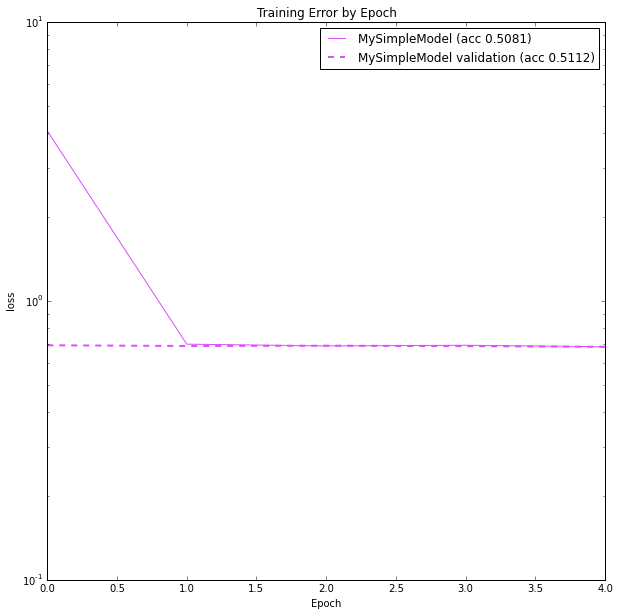

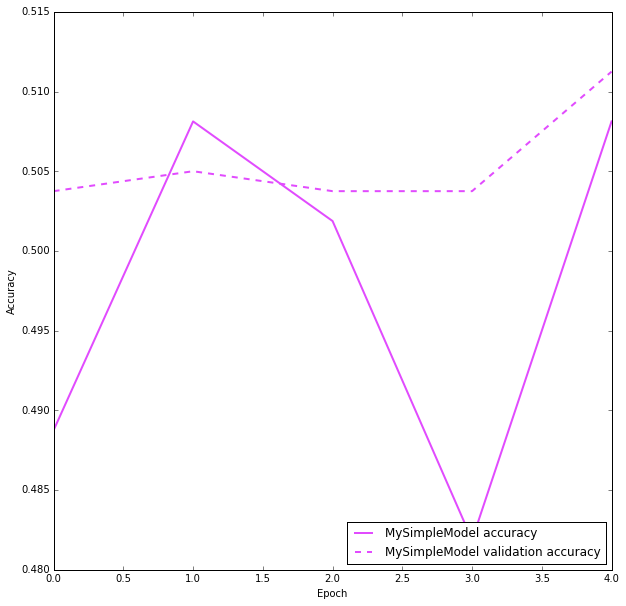

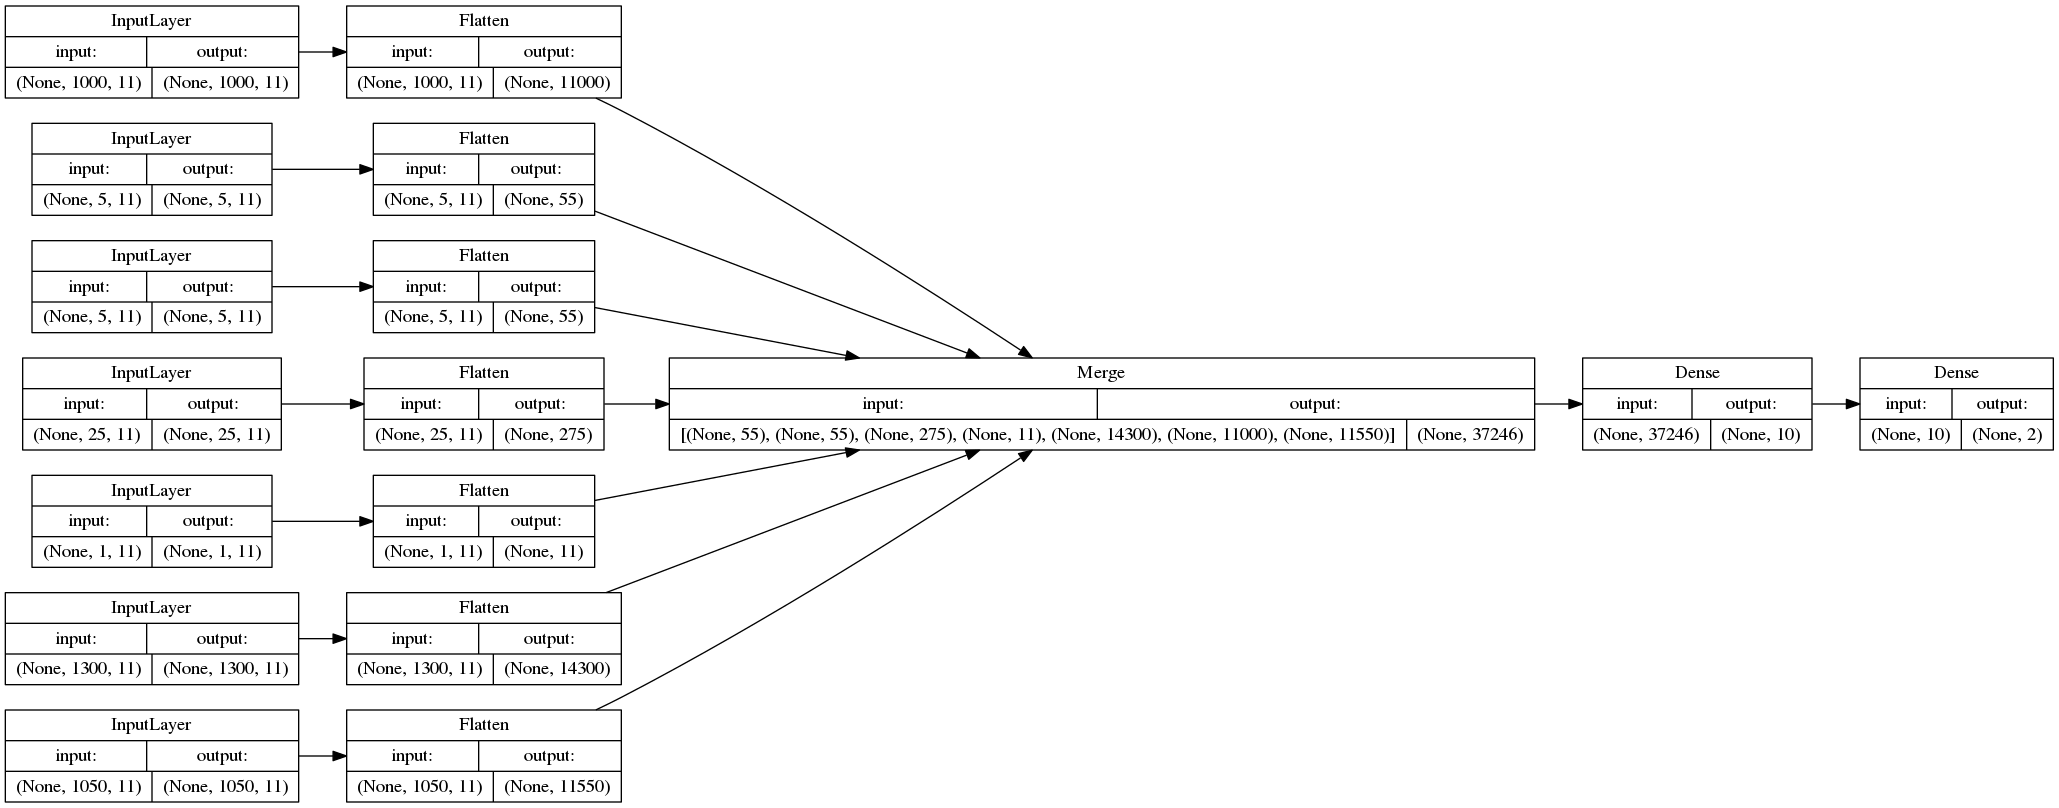

In [3]:
def genModel(depth, width):
    inputs = [None] * len(object_profiles)
    fist_layer = [None] * len(object_profiles)
    #Build Inputs
    for i,profile in enumerate(object_profiles):
        key = profile.name
        max_size = profile.max_size
        inp = Input(shape=(max_size, vecsize), name=key)
        inputs[i] = inp
        fist_layer[i] = Flatten()(inp)
    #Merge inputs
    merged = merge(fist_layer, mode='concat', name="merge")
    a = merged
    v = [width] * depth
    for j in range(len(v)):
        a = Dense(v[j], activation='relu', name="dense_2_"+str(j))(a)
    second_dense = a 
    
    #Create dense sigmoid layer for classification
    dense_out = Dense(len(label_dir_pairs), activation='sigmoid', name='main_output')(second_dense)
    dense = Model(input=inputs, output=dense_out, name="dense")
    return dense

#Get the training data
X_train, Y_train = preprocessFromPandas_label_dir_pairs(label_dir_pairs,
                                                        sample_start,
                                                        num_samples,
                                                        object_profiles,
                                                        observ_types)

#Generate the model from our function above
model = genModel(1,10)
model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy']
              )

#VERY FEW EPOCHS FOR ILLUSTRATIVE REASONS
epochs = 5
batch_size = 100

history = model.fit(X_train, Y_train, batch_size=batch_size,
                nb_epoch=epochs,
                validation_split=.2,
                #YOU SHOULD REALLY USE CALLBACKS AND INCREASE THE # of EPOCHS TO LIKE 100
                callbacks=[])

plot_history([("MySimpleModel", history)])
dot = plot(model, to_file="MySimpleModel.png", show_shapes=True, show_layer_names=False)
display(Image("MySimpleModel.png"))